In [1]:
import sys
sys.path.append('../../../')

In [2]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed
from sklearn.metrics import matthews_corrcoef, mean_squared_error

Using backend: pytorch


In [3]:
def pretty(ld, indent=0):
    return None
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [4]:
do_train = True

seed = 4444
set_seed(seed)

metric_filter_1 = 'test_mcc'
metric_filter_2 = 'val_mcc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [5]:
sets_lengths = (0.3, 0.1, 0.6)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = dataset.num_classes

## Baseline

In [6]:
dict_small_acc_train = {}
dict_small_acc_val = {}
dict_small_acc_test = {}
dict_small_rmse_train = {}
dict_small_rmse_val = {}
dict_small_rmse_test = {}
dict_small_mcc_train = {}
dict_small_mcc_val = {}
dict_small_mcc_test = {}

In [7]:
# x_train,x_test,y_train,y_test = train_test_split(dataset.node_features[0].to_numpy(), dataset.targets[0], test_size=0.25, random_state=seed)
g_data = dataset.graphs[0].ndata
feats = g_data['feat']
labels = g_data['label']
train_mask = g_data['train_mask']
val_mask = g_data['val_mask']
test_mask = g_data['test_mask']

# train + val for training, test for test
x_train,x_test = feats[torch.logical_not(test_mask)], feats[test_mask]
y_train,y_test = labels[torch.logical_not(test_mask)], labels[test_mask]

In [8]:
x_train.shape

torch.Size([600, 4])

In [9]:
x_test.shape

torch.Size([900, 4])

### Logistic Regression

In [10]:
model_lr = LogisticRegression(multi_class='multinomial',random_state=seed, max_iter=800).fit(x_train, y_train)
print(classification_report(y_true=y_test, y_pred=model_lr.predict(x_test)))

              precision    recall  f1-score   support

           0       0.79      0.65      0.72       220
           1       0.23      0.03      0.06       230
           2       0.34      0.50      0.41       231
           3       0.48      0.77      0.59       219

    accuracy                           0.48       900
   macro avg       0.46      0.49      0.44       900
weighted avg       0.46      0.48      0.44       900



In [11]:
dict_small_acc_train['logistic_regression'] = model_lr.score(x_train, y_train)
dict_small_acc_test['logistic_regression'] = model_lr.score(x_test, y_test)
print(f"Train accuracy: {dict_small_acc_train['logistic_regression']}")
print(f"Test accuracy: {dict_small_acc_test['logistic_regression']}")

dict_small_rmse_train['logistic_regression'] = mean_squared_error(y_true=y_train,y_pred=model_lr.predict(x_train), squared=False)
dict_small_rmse_test['logistic_regression'] = mean_squared_error(y_true=y_test,y_pred=model_lr.predict(x_test), squared=False)
print(f"Train rmse: {dict_small_rmse_train['logistic_regression']}")
print(f"Test rmse: {dict_small_rmse_test['logistic_regression']}")

dict_small_mcc_train['logistic_regression'] = matthews_corrcoef(y_true=y_train,y_pred=model_lr.predict(x_train))
dict_small_mcc_test['logistic_regression'] = matthews_corrcoef(y_true=y_test,y_pred=model_lr.predict(x_test))
print(f"Train mcc: {dict_small_mcc_train['logistic_regression']}")
print(f"Test mcc: {dict_small_mcc_test['logistic_regression']}")

Train accuracy: 0.485
Test accuracy: 0.48333333333333334
Train rmse: 0.9703951085339758
Test rmse: 1.0060925515191046
Train mcc: 0.327749651542914
Test mcc: 0.33069737451215436


### Random Forest

In [12]:
# x_train_rf,x_val_rf,y_train_rf,y_val_rf = train_test_split(x_train, y_train, test_size=0.2, random_state=seed)
x_train_rf,x_val_rf,x_test_rf = feats[train_mask], feats[val_mask], feats[test_mask]
y_train_rf,y_val_rf,y_test_rf = labels[train_mask], labels[val_mask], labels[test_mask]

In [13]:
n = 20
num_nodes = x_train_rf.shape[0]
model_rf = None
val_acc = 0.0
for k in trange(1,num_nodes, (num_nodes - 1) // n):
    tmp = RandomForestClassifier(random_state=seed, n_estimators=k).fit(x_train_rf,y_train_rf)
    tmp_acc = tmp.score(x_val_rf, y_val_rf)
    if val_acc < tmp_acc:
        val_acc = tmp_acc
        model_rf = tmp

print(classification_report(y_true=y_test, y_pred=model_rf.predict(x_test)))

100%|██████████| 21/21 [00:05<00:00,  3.73it/s]

              precision    recall  f1-score   support

           0       0.66      0.70      0.68       220
           1       0.29      0.20      0.24       230
           2       0.35      0.32      0.33       231
           3       0.48      0.64      0.55       219

    accuracy                           0.46       900
   macro avg       0.44      0.46      0.45       900
weighted avg       0.44      0.46      0.45       900



In [14]:
model_rf

RandomForestClassifier(n_estimators=221, random_state=4444)

In [15]:
dict_small_acc_train['random_forest'] = model_rf.score(x_train_rf, y_train_rf)
dict_small_acc_val['random_forest'] = model_rf.score(x_val_rf, y_val_rf)
dict_small_acc_test['random_forest'] = model_rf.score(x_test, y_test)
print(f"Train accuracy: {dict_small_acc_train['random_forest']}")
print(f"Val accuracy: {dict_small_acc_val['random_forest']}")
print(f"Test accuracy: {dict_small_acc_test['random_forest']}")

dict_small_rmse_train['random_forest'] = mean_squared_error(y_true=y_train_rf,y_pred=model_rf.predict(x_train_rf), squared=False)
dict_small_rmse_val['random_forest'] = mean_squared_error(y_true=y_val_rf,y_pred=model_rf.predict(x_val_rf), squared=False)
dict_small_rmse_test['random_forest'] = mean_squared_error(y_true=y_test,y_pred=model_rf.predict(x_test), squared=False)
print(f"Train rmse: {dict_small_rmse_train['random_forest']}")
print(f"Val rmse: {dict_small_rmse_val['random_forest']}")
print(f"Test rmse: {dict_small_rmse_test['random_forest']}")

dict_small_mcc_train['random_forest'] = matthews_corrcoef(y_true=y_train_rf,y_pred=model_rf.predict(x_train_rf))
dict_small_mcc_val['random_forest'] = matthews_corrcoef(y_true=y_val_rf,y_pred=model_rf.predict(x_val_rf))
dict_small_mcc_test['random_forest'] = matthews_corrcoef(y_true=y_test,y_pred=model_rf.predict(x_test))
print(f"Train mcc: {dict_small_mcc_train['random_forest']}")
print(f"Val mcc: {dict_small_mcc_val['random_forest']}")
print(f"Test mcc: {dict_small_mcc_test['random_forest']}")

Train accuracy: 1.0
Val accuracy: 0.5133333333333333
Test accuracy: 0.46
Train rmse: 0.0
Val rmse: 1.0132456102380443
Test rmse: 1.043498389499902
Train mcc: 1.0
Val mcc: 0.35709453814743475
Test mcc: 0.2833494878008311


### KNN Classifier

In [16]:
model_knn = KNeighborsClassifier(n_neighbors=out_feats).fit(x_train,y_train)
print(classification_report(y_true=y_test, y_pred=model_knn.predict(x_test)))

              precision    recall  f1-score   support

           0       0.58      0.72      0.65       220
           1       0.28      0.26      0.27       230
           2       0.30      0.29      0.30       231
           3       0.37      0.32      0.34       219

    accuracy                           0.40       900
   macro avg       0.38      0.40      0.39       900
weighted avg       0.38      0.40      0.39       900



In [17]:
dict_small_acc_train['knn_classifier'] = model_knn.score(x_train_rf, y_train_rf)
dict_small_acc_test['knn_classifier'] = model_knn.score(x_test, y_test)
print(f"Train accuracy: {dict_small_acc_train['knn_classifier']}")
print(f"Test accuracy: {dict_small_acc_test['knn_classifier']}")

dict_small_rmse_train['knn_classifier'] = mean_squared_error(y_true=y_train_rf,y_pred=model_knn.predict(x_train_rf), squared=False)
dict_small_rmse_test['knn_classifier'] = mean_squared_error(y_true=y_test,y_pred=model_knn.predict(x_test), squared=False)
print(f"Train rmse: {dict_small_rmse_train['knn_classifier']}")
print(f"Test rmse: {dict_small_rmse_test['knn_classifier']}")

dict_small_mcc_train['knn_classifier'] = matthews_corrcoef(y_true=y_train_rf,y_pred=model_knn.predict(x_train_rf))
dict_small_mcc_test['knn_classifier'] = matthews_corrcoef(y_true=y_test,y_pred=model_knn.predict(x_test))
print(f"Train mcc: {dict_small_mcc_train['knn_classifier']}")
print(f"Test mcc: {dict_small_mcc_test['knn_classifier']}")

Train accuracy: 0.6333333333333333
Test accuracy: 0.39666666666666667
Train rmse: 0.9333333333333333
Test rmse: 1.2233832869001713
Train mcc: 0.5127710052974092
Test mcc: 0.19628592514030305


### FNN

In [18]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

# fnn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_nodes = [None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1, 1e-1, 1e-2],
#     label_smoothing=[0.0, 0.2, 0.4],
# )

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[10, 15], [10, 15, 20], [5, 10, 15], [15] * 2, [15] * 3],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    label_smoothing=[0.0, 0.2],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

In [19]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=False,
        )

100%|██████████| 60/60 [02:56<00:00,  2.95s/it]


#### Results

In [20]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 1156/1156 [00:46<00:00, 25.03it/s]


In [21]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': False,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 1.0788074,
 'train_acc': 0.4955555498600006,
 'val_acc': 0.4999999403953552,
 'epoch': 40,
 'model_class': 'fnn',
 'path_name': '0.50_4_[15_15_15]_4_ReLU()_gn_0.0_0.1_adamw_max_val_mcc_0.0_False_False_0_40',
 'train_mcc': 0.3497028987664788,
 'val_mcc': 0.3652310396224437,
 'test_mcc': 0.37587540447587786,
 'train_rmse': 0.9752492558885196,
 'val_rmse': 0.9273618495495703,
 'test_rmse': 0.9597453365925313,
 'test_acc': 0.5122222304344177}

In [22]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': False,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 1.0661064,
 'train_acc': 0.4977777898311615,
 'val_acc': 0.5199999213218689,
 'epoch': 47,
 'model_class': 'fnn',
 'path_name': '0.52_4_[15_15_15]_4_ReLU()_gn_0.0_0.1_adamw_max_val_mcc_0.0_False_False_0',
 'train_mcc': 0.35355009715326224,
 'val_mcc': 0.40042835412809447,
 'test_mcc': 0.37806302275577086,
 'train_rmse': 0.9556847457887634,
 'val_rmse': 0.9055385138137416,
 'test_rmse': 0.9321420969406375,
 'test_acc': 0.5111111402511597}

In [23]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.2,
 'train_use_edge_weight': False,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 1.1720711,
 'train_acc': 0.5066666603088379,
 'val_acc': 0.5533332824707031,
 'epoch': 96,
 'model_class': 'fnn',
 'path_name': '0.55_4_[10_15_20]_4_ReLU()_bn_0.0_0.1_adamw_max_val_mcc_0.2_False_False_0',
 'train_mcc': 0.3531003122139862,
 'val_mcc': 0.43411593996190306,
 'test_mcc': 0.33526454326613775,
 'train_rmse': 0.9309493362512627,
 'val_rmse': 0.9201449161228175,
 'test_rmse': 0.9706813185707357,
 'test_acc': 0.4911110997200012}

In [24]:
pretty([all[k]['dict'] for k in sort_idx])

### Baseline Overall

In [25]:
print(dict_small_acc_train)
print(dict_small_acc_val)
print(dict_small_acc_test)

{'logistic_regression': 0.485, 'random_forest': 1.0, 'knn_classifier': 0.6333333333333333}
{'random_forest': 0.5133333333333333}
{'logistic_regression': 0.48333333333333334, 'random_forest': 0.46, 'knn_classifier': 0.39666666666666667}


In [26]:
print(dict_small_mcc_train)
print(dict_small_mcc_val)
print(dict_small_mcc_test)

{'logistic_regression': 0.327749651542914, 'random_forest': 1.0, 'knn_classifier': 0.5127710052974092}
{'random_forest': 0.35709453814743475}
{'logistic_regression': 0.33069737451215436, 'random_forest': 0.2833494878008311, 'knn_classifier': 0.19628592514030305}


In [27]:
print(dict_small_rmse_train)
print(dict_small_rmse_val)
print(dict_small_rmse_test)

{'logistic_regression': 0.9703951085339758, 'random_forest': 0.0, 'knn_classifier': 0.9333333333333333}
{'random_forest': 1.0132456102380443}
{'logistic_regression': 1.0060925515191046, 'random_forest': 1.043498389499902, 'knn_classifier': 1.2233832869001713}


### GCN

In [28]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 5, [15] * 4, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    label_smoothing=[0.0, 0.2],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     # h_features=[[5, 10], [10, 15], [5], [10], [15], [10,15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0, 0.2, 0.4],
#     use_edge_weight=[True, False],
#     drop_edges=[0,0.2,0.4],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [29]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=use_edge_weight,
        )

100%|██████████| 192/192 [17:41<00:00,  5.53s/it]


#### Results

In [30]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 3459/3459 [02:56<00:00, 19.62it/s]


In [31]:
res_edges = res_edges_gcn
res_edges[0]

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 1.3561646,
 'train_acc': 0.5444444417953491,
 'val_acc': 0.559999942779541,
 'epoch': 30,
 'model_class': 'gcn',
 'path_name': '0.56_4_[5_10_15_20]_4_ReLU()_none_gn_0.0_0.1_adamw_max_val_mcc_0.0_True_True_0_30',
 'train_mcc': 0.4001372932071248,
 'val_mcc': 0.409299191871014,
 'test_mcc': 0.3767260555923535,
 'train_rmse': 0.941629792788369,
 'val_rmse': 0.9966610925150702,
 'test_rmse': 0.9786612170602133,
 'test_acc': 0.5299999713897705}

In [32]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 1.23324,
 'train_acc': 0.5244444608688354,
 'val_acc': 0.5466666221618652,
 'epoch': 50,
 'model_class': 'gcn',
 'path_name': '0.55_4_[10_15_20]_4_ReLU()_none_gn_0.0_0.1_adamw_max_val_mcc_0.0_True_True_0.2_50',
 'train_mcc': 0.40933521799283,
 'val_mcc': 0.42718146399291657,
 'test_mcc': 0.3955329855625557,
 'train_rmse': 0.8339997335464536,
 'val_rmse': 0.8082903768654761,
 'test_rmse': 0.8875684637129565,
 'test_acc': 0.5144444704055786}

In [33]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'dropout': 0.2,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 1.3221985,
 'train_acc': 0.5266666412353516,
 'val_acc': 0.5933332443237305,
 'epoch': 21,
 'model_class': 'gcn',
 'path_name': '0.59_4_[5_10_15_20]_4_ReLU()_none_gn_0.2_0.1_adamw_max_val_mcc_0.0_True_True_0',
 'train_mcc': 0.39365244302676805,
 'val_mcc': 0.46688271160724987,
 'test_mcc': 0.33489165097773294,
 'train_rmse': 0.9672412085697939,
 'val_rmse': 0.9055385138137416,
 'test_rmse': 1.0754843869934452,
 'test_acc': 0.4866666793823242}

In [34]:
pretty([all[k]['dict'] for k in sort_idx])

### GraphSAGE

In [35]:
save_model = f'{save_path}_sage'
log_dir = f'{log_path}_sage'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
    out_features = [out_feats],
    # aggregator_type = ['mean', 'lstm'],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    label_smoothing=[0.0, 0.2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[25] * 3, [20] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [36]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=use_edge_weight,
        )

100%|██████████| 288/288 [3:29:17<00:00, 43.60s/it]  


#### Results

In [37]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 6414/6414 [22:04<00:00,  4.84it/s]


In [38]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [20, 25, 20],
 'out_features': 4,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.017089361,
 'train_acc': 0.8288888931274414,
 'val_acc': 0.8666665554046631,
 'epoch': 95,
 'model_class': 'sage',
 'path_name': '0.87_4_[20_25_20]_4_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_0.0_True_True_0',
 'train_mcc': 0.7731753186399242,
 'val_mcc': 0.8239210802476856,
 'test_mcc': 0.8468932103005018,
 'train_rmse': 0.42946995755750417,
 'val_rmse': 0.39157800414902433,
 'test_rmse': 0.38005847503304596,
 'test_acc': 0.8844444155693054}

In [39]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 25, 20],
 'out_features': 4,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.01639062,
 'train_acc': 0.8266666531562805,
 'val_acc': 0.8666665554046631,
 'epoch': 100,
 'model_class': 'sage',
 'path_name': '0.87_4_[20_25_20]_4_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_0.0_True_True_0_100',
 'train_mcc': 0.7698291993318429,
 'val_mcc': 0.8239210802476856,
 'test_mcc': 0.8469660025670589,
 'train_rmse': 0.43204937989385733,
 'val_rmse': 0.39157800414902433,
 'test_rmse': 0.3756475889861548,
 'test_acc': 0.8844444155693054}

In [40]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25, 25, 25],
 'out_features': 4,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.2,
 'train_use_edge_weight': True,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.64922774,
 'train_acc': 0.8422222137451172,
 'val_acc': 0.8999999165534973,
 'epoch': 87,
 'model_class': 'sage',
 'path_name': '0.83_4_[25_25_25]_4_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_0.2_True_True_0',
 'train_mcc': 0.7908008973463515,
 'val_mcc': 0.8673078981098846,
 'test_mcc': 0.7902019359130029,
 'train_rmse': 0.5055250296034367,
 'val_rmse': 0.34641016151377546,
 'test_rmse': 0.4702245326555295,
 'test_acc': 0.8422222137451172}

In [41]:
pretty([all[k]['dict'] for k in sort_idx])

#### cm

In [42]:
cm = all[sort_idx[0]]['test_cm'][0]

In [43]:
(cm.labels==0).sum()

tensor(214)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

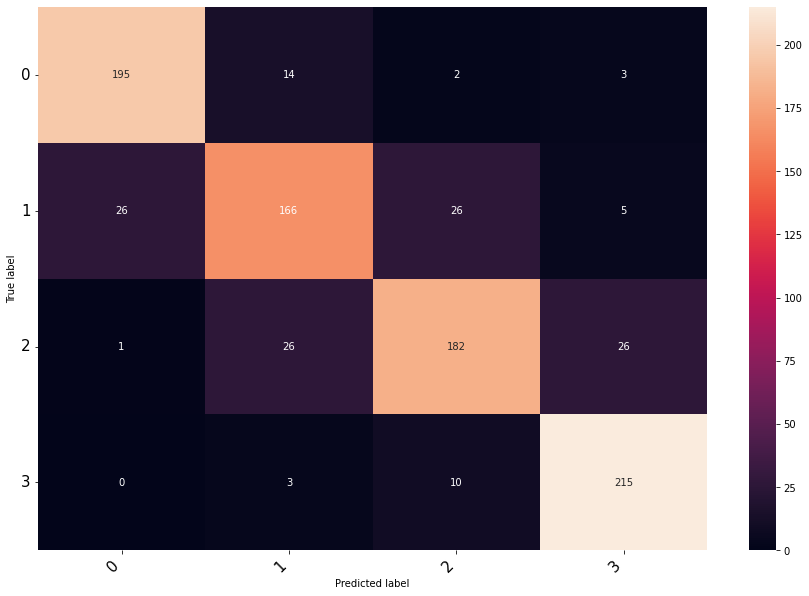

In [44]:
cm.visualize()

In [45]:
cm.class_accuracy

tensor([0.9112, 0.7444, 0.7745, 0.9430])

### GAT

In [46]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10], [10] * 2, [15], [15] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2, [4, 2]],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    label_smoothing=[0.0, 0.2],
    use_edge_weight=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [47]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=use_edge_weight,
        )

100%|██████████| 576/576 [1:04:25<00:00,  6.71s/it]


#### Results

In [48]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 11355/11355 [11:19<00:00, 16.72it/s]


In [49]:
res_edges = res_edges_gat
res_edges[0]

{'in_features': 4,
 'h_features': [15],
 'out_features': 4,
 'num_heads': [4, 4],
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 1.2272773,
 'train_acc': 0.5244444608688354,
 'val_acc': 0.5466666221618652,
 'epoch': 75,
 'model_class': 'gat',
 'path_name': '0.55_4_[15]_4_[4_4]_bn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_0.0_True_True_0',
 'train_mcc': 0.3698335801359395,
 'val_mcc': 0.40584818256367144,
 'test_mcc': 0.403202961170569,
 'train_rmse': 1.028483241369434,
 'val_rmse': 1.0132456102380443,
 'test_rmse': 0.9285592184789413,
 'test_acc': 0.550000011920929}

In [50]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15],
 'out_features': 4,
 'num_heads': [4, 4],
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 1.2272773,
 'train_acc': 0.5244444608688354,
 'val_acc': 0.5466666221618652,
 'epoch': 75,
 'model_class': 'gat',
 'path_name': '0.55_4_[15]_4_[4_4]_bn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_0.0_True_True_0',
 'train_mcc': 0.3698335801359395,
 'val_mcc': 0.40584818256367144,
 'test_mcc': 0.403202961170569,
 'train_rmse': 1.028483241369434,
 'val_rmse': 1.0132456102380443,
 'test_rmse': 0.9285592184789413,
 'test_acc': 0.550000011920929}

In [51]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20],
 'out_features': 4,
 'num_heads': [4, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.2,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 1.2147855,
 'train_acc': 0.5177778005599976,
 'val_acc': 0.606666624546051,
 'epoch': 75,
 'model_class': 'gat',
 'path_name': '0.61_4_[20]_4_[4_2]_gn_ReLU()_0.2_0.2_0.2_True_0.01_adamw_max_val_mcc_0.0_True_True_0',
 'train_mcc': 0.35758708735007677,
 'val_mcc': 0.4773227331642924,
 'test_mcc': 0.37971044098667267,
 'train_rmse': 1.0066445913694333,
 'val_rmse': 0.9486832980505138,
 'test_rmse': 0.9237604307034013,
 'test_acc': 0.5322222113609314}

In [52]:
pretty([all[k]['dict'] for k in sort_idx])